## 7. To Do : Mise au point d'un classifieur profond sur les données Mnist (Passer en première lecture)

https://www.kaggle.com/c/digit-recognizer

Vous devez :

- Vous enregistrer sur Kaggle
- Récupérer les données de la compétition digit-recognizer
- Soumettre des prédictions sur les données de test.
- Me fournir par mail d'ici la prochaine séance votre login Kaggle et la performance que vous avez obtenue.

Pour cela vous pourrez suivre, notamment, les pistes évoquées ci-dessous (non exclusives).

Dans tous les cas vous ferez attention à avoir une bonne estimation de la performance en généralisation avant de soumettre un RUN sur Kaggle.
### Piste 1 : Accroître la quantité de données et leur variabilité  

- En bruitant les données (bruit à définir)
- En rajoutant les images miroirs
- En utilisant les pistes décrites ici  http://leon.bottou.org/projects/infimnist
Vous pourrez utiliser [ImageDataGenerator](https://keras.io/preprocessing/image/) de Keras.
### Piste 2 : Exploiter la technique du dropout

En vous inspirant de résultats et d'indications publiés dans
https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

La couche de Dropout de Keras est définie [ici](https://keras.io/layers/core/).


In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Load the data
train_data = pd.read_csv('digit-recognizer/train.csv')
test_data = pd.read_csv('digit-recognizer/test.csv')

In [5]:
# Split the data into features and labels
X = train_data.drop('label', axis=1).values
y = train_data['label'].values

In [6]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_test = test_data.values
X_test_scaled = scaler.transform(X_test)

In [8]:
# Turn our scalar targets into binary categories
num_classes = train_data['label'].nunique()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [9]:
print(f'X_train Shape: {X_train_scaled.shape}')
print(f'y_train Data Shape: {y_train.shape}')
print(f'X_val Shape: {X_val_scaled.shape}')
print(f'y_val Data Shape: {y_val.shape}')

X_train Shape: (33600, 784)
y_train Data Shape: (33600, 10)
X_val Shape: (8400, 784)
y_val Data Shape: (8400, 10)


In [10]:
# Reshape the image data for the convolutional network
X_train_scaled = X_train_scaled.reshape(-1, 28, 28, 1)
X_val_scaled = X_val_scaled.reshape(-1, 28, 28, 1)
X_test_scaled = X_test_scaled.reshape(-1, 28, 28, 1)

In [11]:
print(f'X_train Shape: {X_train_scaled.shape}')
print(f'y_train Data Shape: {y_train.shape}')
print(f'X_val Shape: {X_val_scaled.shape}')
print(f'y_val Data Shape: {y_val.shape}')

X_train Shape: (33600, 28, 28, 1)
y_train Data Shape: (33600, 10)
X_val Shape: (8400, 28, 28, 1)
y_val Data Shape: (8400, 10)


In [13]:
datagen = ImageDataGenerator(
    rotation_range=10,       
    zoom_range=0.1,          
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    horizontal_flip=False,   
    vertical_flip=False,     
) 

In [15]:
batch_size = 64

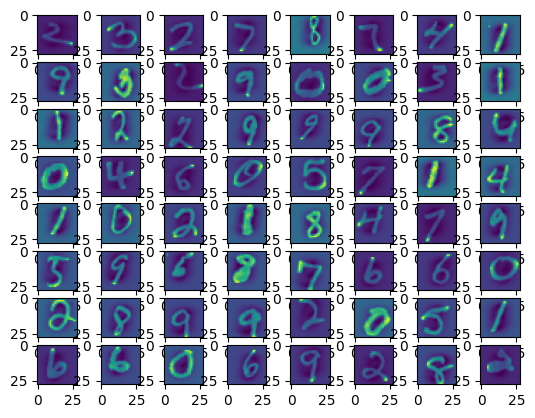

In [16]:
img_iter = datagen.flow(X_train_scaled, y_train, batch_size=batch_size)

x, y = next(img_iter)
fig, ax = plt.subplots(nrows=int(batch_size/8), ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [17]:
datagen.fit(X_train_scaled)

In [19]:
# Define the model architecture - VGG like architecture
model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=10, activation="softmax"))

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(img_iter,
          epochs=10,
          steps_per_epoch=len(X_train_scaled)//batch_size,
          validation_steps=len(X_test_scaled)//batch_size,
          validation_data=(X_val_scaled, y_val))

Epoch 1/10
525/525 [==============================] - 128s 237ms/step - loss: 0.3483 - accuracy: 0.8925 - val_loss: 0.1339 - val_accuracy: 0.9650
Epoch 2/10
352/525 [===================>..........] - ETA: 37s - loss: 0.1359 - accuracy: 0.9589

KeyboardInterrupt: 

In [58]:
# Print the values of the model.history.history dictionary
print(model.history)

{'loss': [0.017673281952738762, 0.015410061925649643, 0.02086460404098034, 0.01259977463632822, 0.022961437702178955, 0.007673314306885004, 0.011478470638394356, 0.022833531722426414, 0.02745898626744747, 0.018999377265572548, 0.022045815363526344, 0.016096193343400955, 0.023692447692155838, 0.014497348107397556, 0.011426126584410667, 0.0083777429535985, 0.014077169820666313, 0.008502000942826271, 0.017204243689775467, 0.02174573577940464, 0.02524203434586525, 0.03124292567372322, 0.010955523699522018, 0.011392900720238686, 0.021621793508529663, 0.008463180623948574, 0.011041798628866673, 0.022701242938637733, 0.03053181990981102, 0.005742094945162535, 0.004429677966982126, 0.019901521503925323, 0.015767421573400497, 0.032459210604429245, 0.007430977188050747, 0.011726382188498974, 0.013845793902873993, 0.008797545917332172, 0.031090397387742996, 0.06529740989208221, 0.02164674736559391, 0.010748348198831081, 0.009918964467942715, 0.03049301542341709, 0.012122346088290215, 0.0167006216

In [59]:
# Extract the values of loss and accuracy
loss = model.history['loss']
val_loss = model.history['val_loss']
accuracy = model.history['accuracy']
val_accuracy = model.history['val_accuracy']

In [60]:
print(loss)

[0.017673281952738762, 0.015410061925649643, 0.02086460404098034, 0.01259977463632822, 0.022961437702178955, 0.007673314306885004, 0.011478470638394356, 0.022833531722426414, 0.02745898626744747, 0.018999377265572548, 0.022045815363526344, 0.016096193343400955, 0.023692447692155838, 0.014497348107397556, 0.011426126584410667, 0.0083777429535985, 0.014077169820666313, 0.008502000942826271, 0.017204243689775467, 0.02174573577940464, 0.02524203434586525, 0.03124292567372322, 0.010955523699522018, 0.011392900720238686, 0.021621793508529663, 0.008463180623948574, 0.011041798628866673, 0.022701242938637733, 0.03053181990981102, 0.005742094945162535, 0.004429677966982126, 0.019901521503925323, 0.015767421573400497, 0.032459210604429245, 0.007430977188050747, 0.011726382188498974, 0.013845793902873993, 0.008797545917332172, 0.031090397387742996, 0.06529740989208221, 0.02164674736559391, 0.010748348198831081, 0.009918964467942715, 0.03049301542341709, 0.012122346088290215, 0.0167006216943264, 0

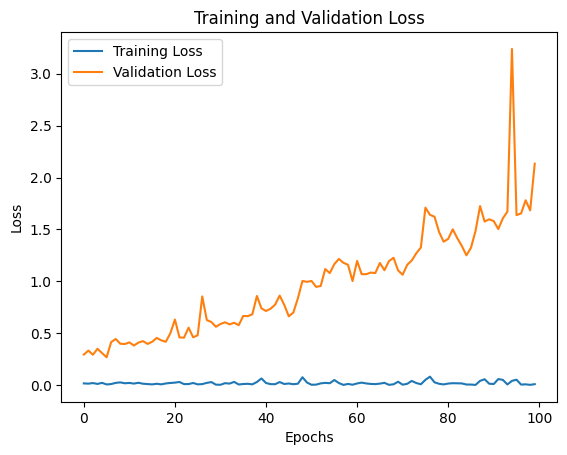

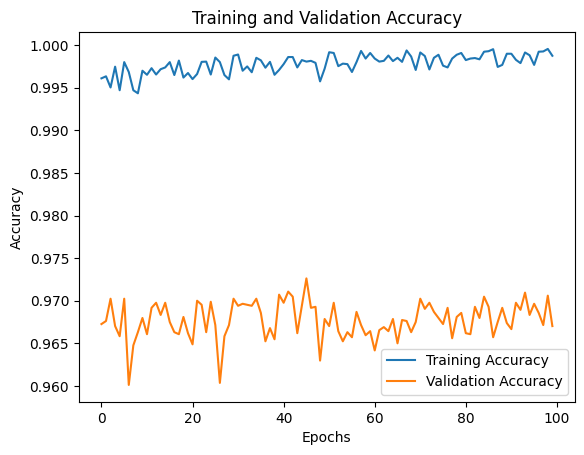

In [61]:
# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [63]:
predictions = model.predict(X_test_scaled)

875/875 [==============================] - 2s 2ms/step


In [64]:
# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

In [65]:
# Plot a random sample of images with their predicted labels
num_samples = 10
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

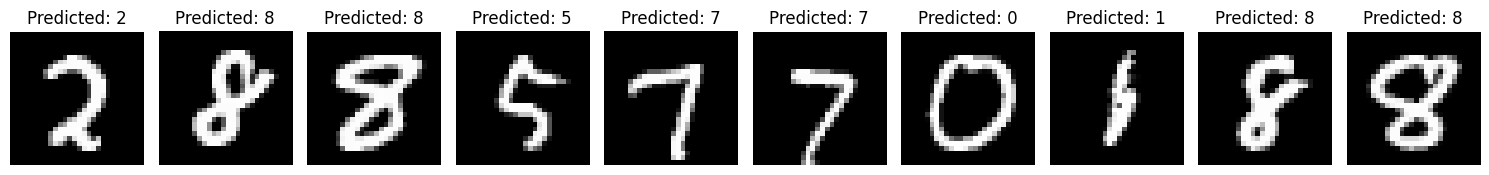

In [66]:
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    image = X_test[idx]
    label = predicted_labels[idx]
    
    axes[i].imshow(image.reshape(28,28), cmap='gray')
    axes[i].set_title(f'Predicted: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()